In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from transformers import logging
logging.set_verbosity_error()

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [4]:
with open('Korean_movie_reviews_2016_small.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f ]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

In [5]:
len(texts)

29875

In [6]:
from transformers import AutoTokenizer, TFElectraForSequenceClassification

In [7]:
tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base-v2022")

Downloading:   0%|          | 0.00/288 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/504 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [8]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(labels)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts, y_one_hot, test_size=0.2, random_state=0)

In [10]:
len(X_train)

23900

In [11]:
X_train_tokenized = tokenizer(X_train, return_tensors="np", max_length=30, padding='max_length', truncation=True)
X_test_tokenized = tokenizer(X_test, return_tensors="np", max_length=30, padding='max_length', truncation=True)

In [12]:
model = TFElectraForSequenceClassification.from_pretrained("beomi/KcELECTRA-base-v2022", num_labels=2, from_pt=True)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

In [13]:
optimizer = tf.keras.optimizers.Adam(2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = "./checkpoints/checkpoint_electra_kr"
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_best_only=True, save_weights_only=True)

In [15]:
history = model.fit(dict(X_train_tokenized), y_train, epochs=10, batch_size=128, 
                    validation_split=0.1, callbacks=[es, mc])

Epoch 1/10
169/169 [==============================] - 1520s 9s/step - loss: 0.3706 - accuracy: 0.8483 - val_loss: 0.2826 - val_accuracy: 0.8933
Epoch 2/10
169/169 [==============================] - 1501s 9s/step - loss: 0.2079 - accuracy: 0.9221 - val_loss: 0.2489 - val_accuracy: 0.9042
Epoch 3/10
169/169 [==============================] - 1512s 9s/step - loss: 0.1461 - accuracy: 0.9461 - val_loss: 0.2481 - val_accuracy: 0.9063
Epoch 4/10
169/169 [==============================] - 1493s 9s/step - loss: 0.1085 - accuracy: 0.9618 - val_loss: 0.2844 - val_accuracy: 0.9155
Epoch 5/10
169/169 [==============================] - 1500s 9s/step - loss: 0.0752 - accuracy: 0.9756 - val_loss: 0.2999 - val_accuracy: 0.9176
Epoch 6/10
169/169 [==============================] - 1501s 9s/step - loss: 0.0540 - accuracy: 0.9833 - val_loss: 0.3443 - val_accuracy: 0.9100
Epoch 6: early stopping


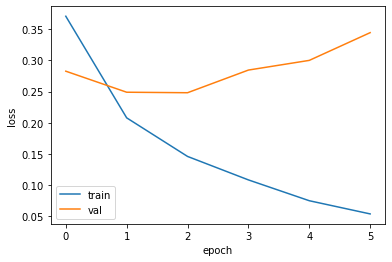

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

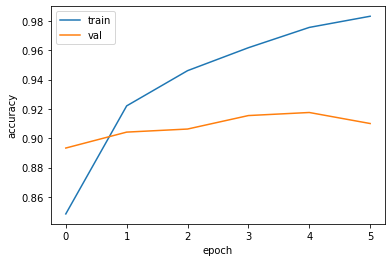

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [18]:
model.load_weights(checkpoint_filepath)
y_preds = model.predict(dict(X_test_tokenized))
prediction_probs = tf.nn.softmax(y_preds.logits,axis=1).numpy()
y_predictions = np.argmax(prediction_probs, axis=1)
y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_predictions, y_test))

187/187 [==============================] - 137s 723ms/step
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      3026
           1       0.89      0.94      0.91      2949

    accuracy                           0.91      5975
   macro avg       0.91      0.91      0.91      5975
weighted avg       0.91      0.91      0.91      5975

